In [1]:
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor

from lcapt.analysis import make_feature_grid
from lcapt.lca import LCAConv2D
from lcapt.metric import compute_l1_sparsity, compute_l2_error

In [2]:
BATCH_SIZE = 64
DEVICE = 0
EPOCHS = 25
FEATURES = 64  # number of dictionary features to learn
KERNEL_SIZE = 9  # height and width of each feature
LAMBDA = 0.05  # LCA threshold
LCA_ITERS = 800
LEARNING_RATE = 1e-2
PRINT_FREQ = 20
STRIDE = 2  # convolutional stride
TAU = 100 # LCA time constant

In [3]:
dset = CIFAR10('./data', download=True, transform=ToTensor())
dataloader = DataLoader(
    dset, 
    BATCH_SIZE, 
    shuffle=True, 
    num_workers=4, 
    pin_memory=True, 
    persistent_workers=True
)

Files already downloaded and verified


In [4]:
lca = LCAConv2D(
    out_neurons=FEATURES,
    in_neurons=3,
    result_dir='./cifar_dictionary_learning',
    kernel_size=KERNEL_SIZE,
    stride=STRIDE,
    lambda_=LAMBDA,
    tau=TAU,
    track_metrics=False,
    eta=LEARNING_RATE,
    return_vars=['inputs', 'acts', 'recons', 'recon_errors'],
)
lca = lca.to(dtype=torch.float16, device=DEVICE)

In [ ]:
for epoch in range(EPOCHS):
    if (epoch + 1) % 4 == 0:
        lca.lambda_ += 0.1

    for batch_num, (images, _) in enumerate(dataloader):
        images = images.to(dtype=torch.float16, device=DEVICE)
        inputs, code, recon, recon_error = lca(images)
        lca.update_weights(code, recon_error)
        if batch_num % PRINT_FREQ == 0:
            l1_sparsity = compute_l1_sparsity(code, lca.lambda_).item()
            l2_recon_error = compute_l2_error(inputs, recon).item()
            total_energy = l2_recon_error + l1_sparsity
            print(f'Epoch: {epoch}; ',
                  f'Batch: {batch_num}; ',
                  f'L2 Recon Error: {round(l2_recon_error, 2)}; ',
                  f'L1 Sparsity: {round(l1_sparsity, 2)}; ',
                  f'Total Energy: {round(total_energy, 2)}')
    torch.save(lca, f'lca_cifar.pt')

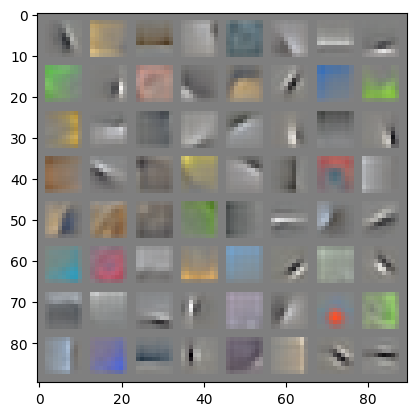

In [16]:
weight_grid = make_feature_grid(lca.get_weights())
plt.imshow(weight_grid.float().cpu().numpy())

Text(0.5, 1.0, 'Input - Reconstruction')

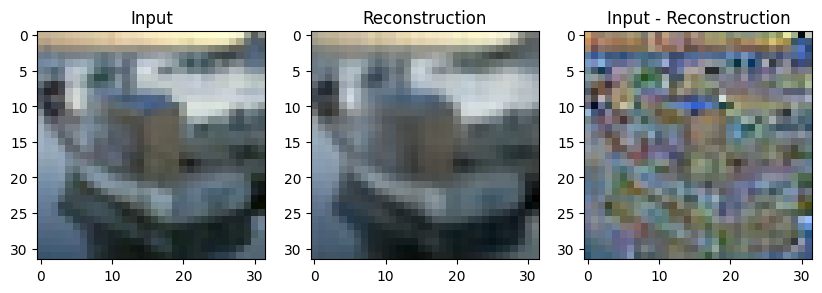

In [17]:
fig, ax = plt.subplots(1, 3, figsize=(10, 3))
recon = recon[0].float().cpu().numpy().transpose(1, 2, 0)
recon_error = recon_error[0].float().cpu().numpy().transpose(1, 2, 0)
inputs = (recon_error + recon)
recon = (recon - recon.min()) / (recon.max() - recon.min())
inputs = (inputs - inputs.min()) / (inputs.max() - inputs.min())
recon_error = (recon_error - recon_error.min()) / (recon_error.max() - recon_error.min())
img1 = ax[0].imshow(inputs)
img2 = ax[1].imshow(recon)
img3 = ax[2].imshow(recon_error)
ax[0].set_title('Input')
ax[1].set_title('Reconstruction')
ax[2].set_title('Input - Reconstruction')